<a href="https://colab.research.google.com/github/o0jayzaza0o/pythonaipidterm/blob/main/Image_classification_Hand_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with FastAI


In [1]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
from PIL import Image

https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste

## Prepare Data
- ใช้ `ImageDataLoaders.from_folder()`
- โฟลเดอร์ข้อมูลควรมีโครงสร้างแบบ:
```
data/
  train/
    class1/
    class2/
```


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vencerlanz09/sea-animals-image-dataste")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sea-animals-image-dataste' dataset.
Path to dataset files: /kaggle/input/sea-animals-image-dataste


In [3]:
import shutil

download_path = "/kaggle/input/sea-animals-image-dataste"

destination_path = "/content/sea-animals-image-dataste"

if os.path.exists(destination_path):
    print(f"Removing existing directory: {destination_path}")
    shutil.rmtree(destination_path)

shutil.move(download_path, destination_path)

OSError: [Errno 30] Read-only file system: '/kaggle/input/sea-animals-image-dataste/Jelly Fish'

In [4]:
import shutil
import os

download_path = "/kaggle/input/sea-animals-image-dataste"
destination_path = "/content/sea-animals-image-dataste"

# 1. Check if the destination already exists and remove it if it does
#    (This part of your original code was correct)
if os.path.exists(destination_path):
    print(f"Removing existing directory: {destination_path}")
    shutil.rmtree(destination_path)

# 2. Use copytree to copy from the read-only source to the writable destination
try:
    print(f"Copying data from {download_path} to {destination_path}...")
    shutil.copytree(download_path, destination_path)
    print("Copy complete.")

except FileNotFoundError:
    print(f"Error: Source path not found: {download_path}")
except Exception as e:
    print(f"An error occurred during copy: {e}")

Removing existing directory: /content/sea-animals-image-dataste
Copying data from /kaggle/input/sea-animals-image-dataste to /content/sea-animals-image-dataste...
Copy complete.



```
dls = ImageDataLoaders.from_folder(
    path,                             # ตำแหน่งของโฟลเดอร์ข้อมูลรูปภาพ แยกตามคลาสย่อยในโฟลเดอร์ย่อย
    valid_pct=0.2,                    # แบ่งข้อมูล 20% สำหรับ validation set เพื่อใช้ประเมินผลระหว่างการเทรน
    seed=42,                          # ตั้งค่า seed เพื่อให้การแบ่งข้อมูล train/valid เหมือนเดิมทุกครั้งที่รัน
    item_tfms=Resize(224),            # ปรับขนาดภาพทั้งหมดให้มีขนาด 224x224 เท่ากันก่อนเข้าสู่ batch
    batch_tfms=aug_transforms(
      do_flip = True,                 # พลิกภาพแบบแนวนอน (Horizontal flip) แบบสุ่ม
      flip_vert = True,               # พลิกภาพแบบแนวตั้ง (Vertical flip) แบบสุ่ม
      max_rotate = 90,                # หมุนภาพแบบสุ่มสูงสุด 90 องศา
      min_zoom = 1,                   # กำหนดการซูมแบบสุ่ม โดยไม่เล็กกว่าขนาดจริง (ขั้นต่ำ = 1 เท่า)
      max_zoom = 4.1,                 # กำหนดการซูมสูงสุดเป็น 4.1 เท่า (ขยายได้มาก)
      max_lighting = 0.2,             # ปรับแสง/คอนทราสต์ของภาพแบบสุ่มในระดับไม่เกิน 20%
      max_warp = 0.2,                 # บิดยืดรูปทรงของภาพแบบ perspective warp ได้ไม่เกิน 20%
      p_affine = 0.75,                # โอกาส 75% ที่จะทำการแปลงแบบ affine (หมุน, ซูม, บิด)
      p_lighting = 0.75,              # โอกาส 75% ที่จะเปลี่ยนแสง/คอนทราสต์ของภาพ
      mode = "bilinear",              # โหมดการปรับภาพ (interpolation) ใช้แบบ bilinear (นุ่มนวล)
      pad_mode = "reflection",        # ถ้าต้อง padding จะใช้ค่าจากการสะท้อนขอบภาพ
    ),
    bs=32                             # จำนวนภาพต่อหนึ่ง batch ขณะ training
)

```



In [5]:

path = Path('/content/sea-animals-image-dataste')
dls = ImageDataLoaders.from_folder(
    path,
    item_tfms=Resize(224),
    valid_pct=0.2,
    batch_tfms=aug_transforms(),
    bs=16
)

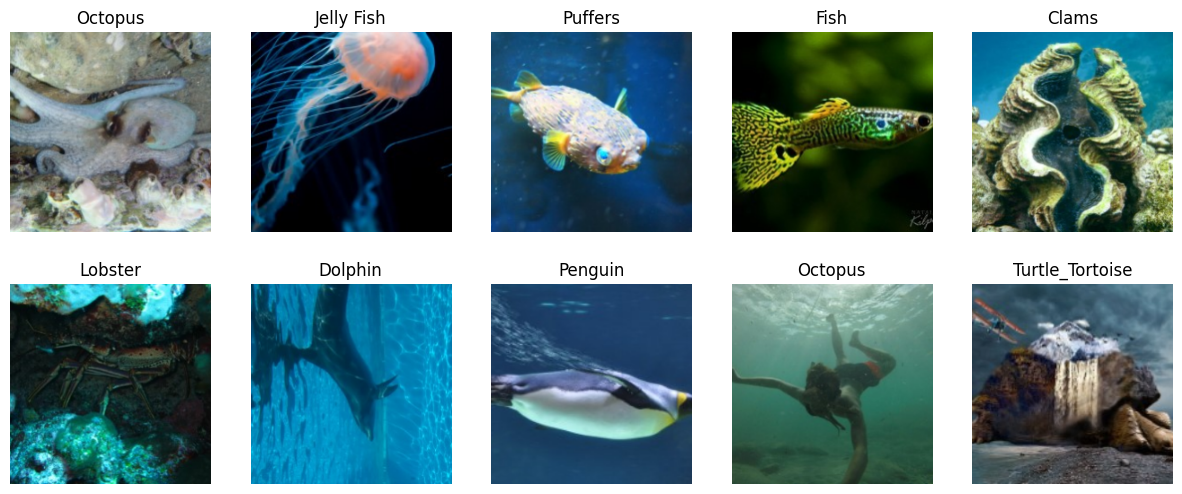

In [7]:
dls.valid.show_batch(max_n=10,nrows=2)

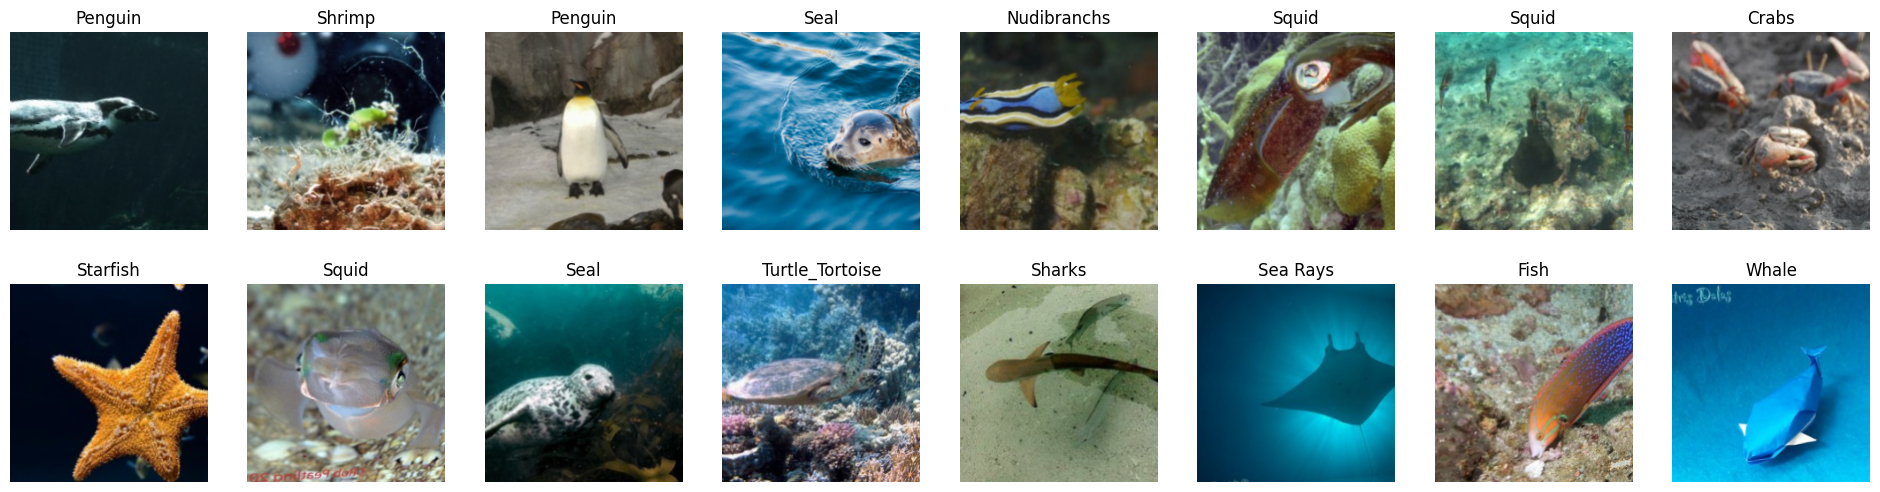

In [6]:
dls.train.show_batch(max_n=20, nrows=2)

In [8]:
dls.vocab

['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']

## Define Learner
- ใช้ `vision_learner()` เพื่อโหลดโมเดลและเมตริก
- โมเดลตัวอย่าง: `resnet18`, `resnet34`, `resnet50` 'dir(models)'

In [9]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]


## Summary

In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
learn.summary()

Sequential (Input shape: 16 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

## Suggest Learning rate

SuggestedLRs(valley=0.0012022644514217973)

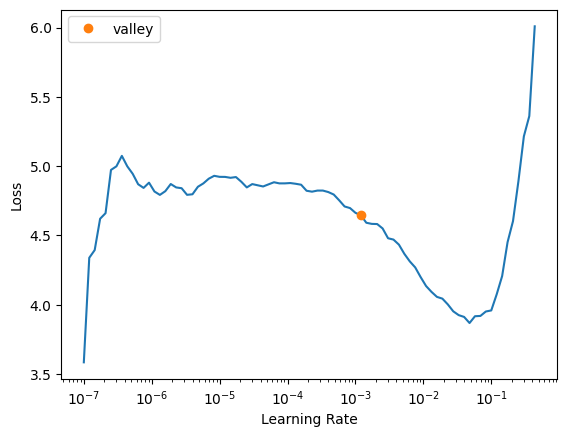

In [12]:
learn.lr_find()

## Train the Model

In [13]:
learn.fine_tune(epochs= 10, base_lr= 0.0012022644514217973 ,freeze_epochs=0 )

## Interpret Results

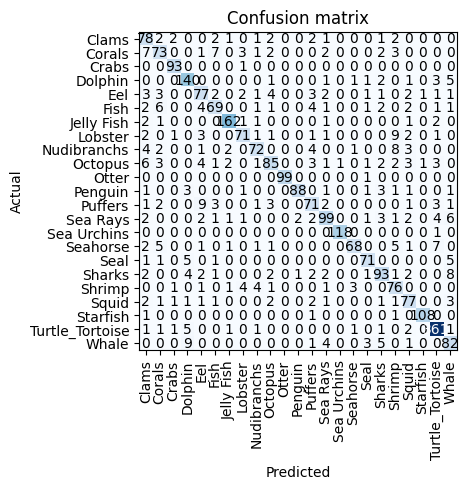

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

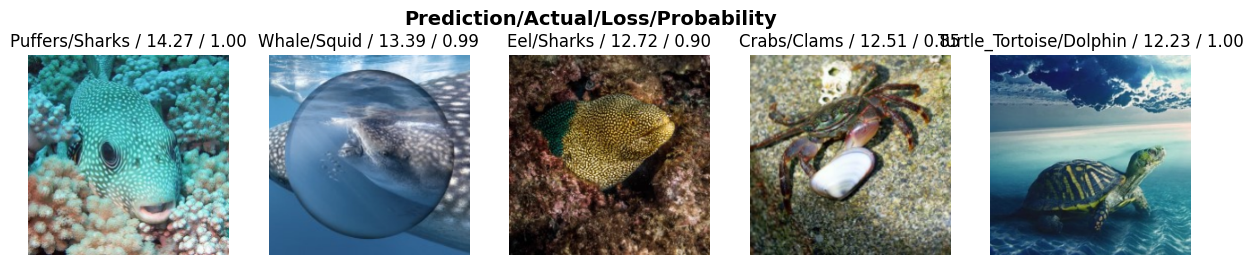

In [15]:
interp.plot_top_losses(5, nrows=1)

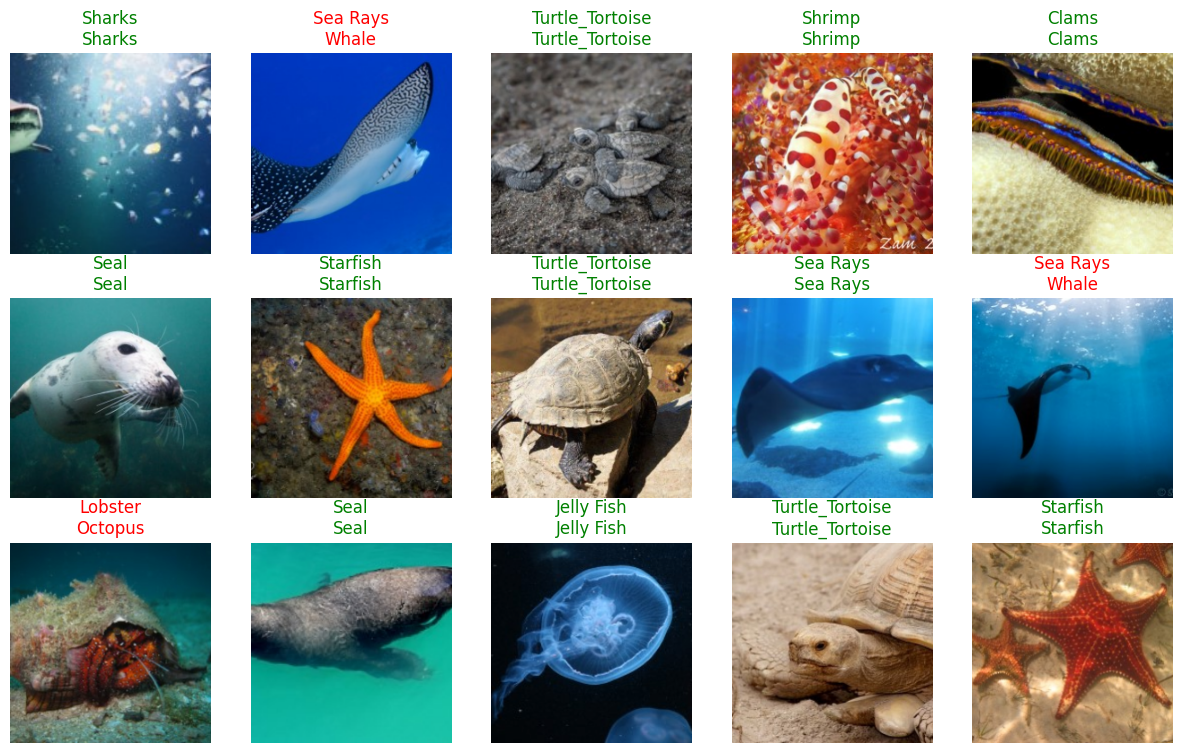

In [16]:
learn.show_results(max_n=15,shuffle=True)

## Testing

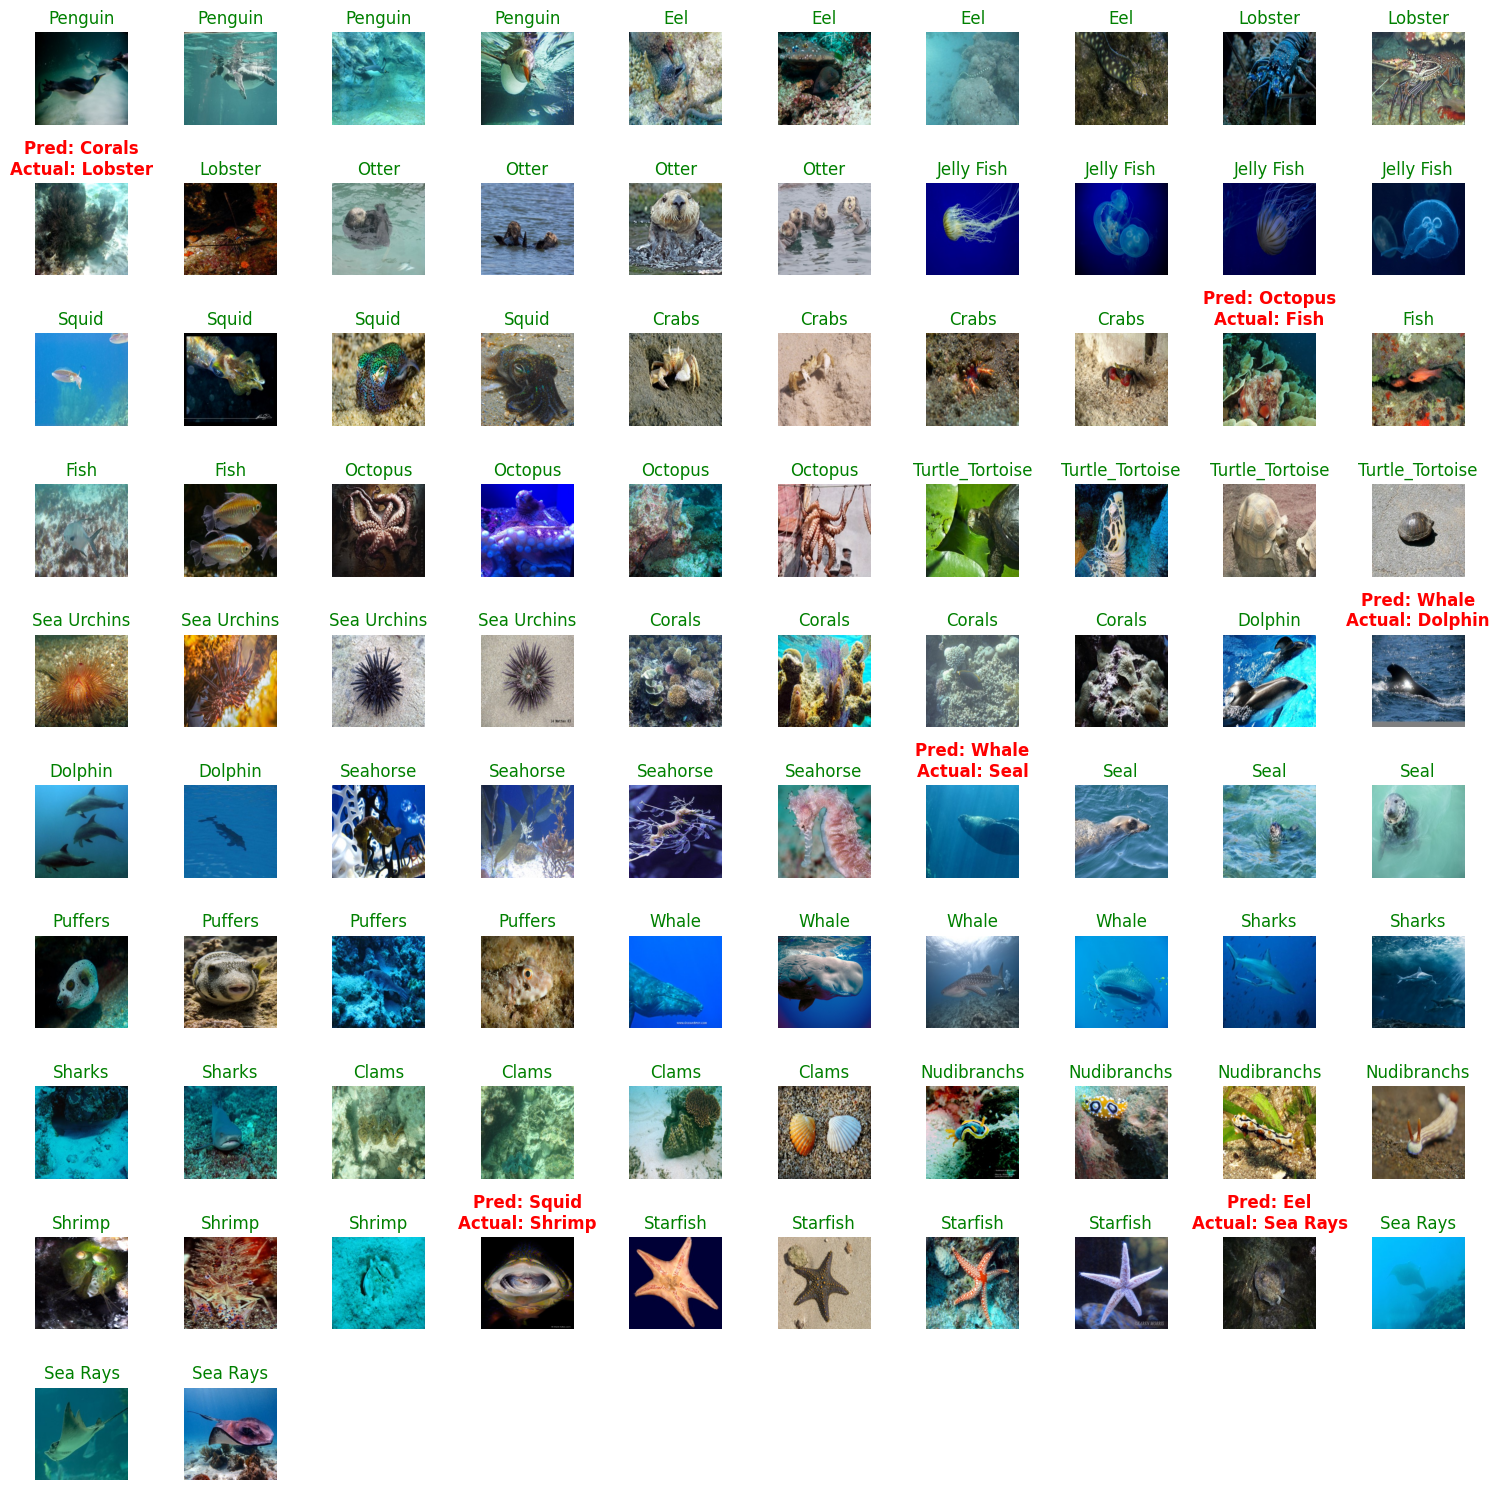

In [17]:
plt.figure(figsize=(15,15)) # Adjusted figure size for more subplots
base_test_path = '/content/sea-animals-image-dataste' # Base path to your test data

c = 0
max_images_to_show = 100 # You can adjust this number
subplot_rows = 10 # Adjust based on max_images_to_show
subplot_cols = 10 # Adjust based on max_images_to_show

# Iterate through each class directory in the test data
for class_name in os.listdir(base_test_path):
    class_path = os.path.join(base_test_path, class_name)
    if os.path.isdir(class_path): # Ensure it's a directory
        # Iterate through images in the current class directory
        for image_name in os.listdir(class_path)[:max_images_to_show // len(os.listdir(base_test_path))]: # Limit images per class
            if c < max_images_to_show: # Stop after showing max_images_to_show
                plt.subplot(subplot_rows, subplot_cols, c + 1) # Use c+1 for subplot index

                image_path = os.path.join(class_path, image_name)
                try:
                    img = Image.open(image_path).resize((200, 200))

                    pred_class, pred_idx, outputs = learn.predict(img)

                    # Set title color based on correct/incorrect prediction
                    if pred_class == class_name:
                        plt.title(pred_class, color='green') # Correct prediction in green
                    else:
                        plt.title(f'Pred: {pred_class}\nActual: {class_name}', color='red', weight='bold') # Incorrect prediction in bold red

                    plt.imshow(img) # Removed cmap='gray' for color images
                    plt.axis('off')
                    c += 1
                except Exception as e:
                    print(f"Could not process image {image_path}: {e}")

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Show the plot

## Export Model

In [18]:
learn.export('learn')

In [19]:
!ls

sample_data  sea-animals-image-dataste
